## Data Loading

To begin our analysis, we first load the datasets provided in the ZIP file. This includes tweet data and stock price data for five companies: Apple (AAPL), Amazon (AMZN), Google (GOOG), Microsoft (MSFT), and Tesla (TSLA) and many more that we will not analyse. The tweet data contains information on the sentiment expressed in tweets about these companies, while the stock price data provides daily stock prices.

In [2]:
## Data Loading

'''To begin our analysis, we first load the datasets provided in the ZIP file. 
This includes tweet data and stock price data for five companies: 
Apple (AAPL), Amazon (AMZN), Google (GOOG), Microsoft (MSFT), and Tesla (TSLA) 
and many more that we will not analyse. The tweet data contains information on the sentiment expressed in tweets about these companies, while the stock price data provides daily stock prices.
'''

import pandas as pd
import os
import zipfile
import warnings
warnings 

# Unzip the file directly in the repo directory
with zipfile.ZipFile('stock-tweet-and-price.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the tweet dataset
tweets_df = pd.read_csv('stock-tweet-and-price/stocktweet/stocktweet.csv')
# List all unique values in the 'ticker' column
unique_tickers = tweets_df['ticker'].unique()
print(unique_tickers)
tweets_df.head()

['AMZN' 'TSLA' 'AAPL' 'HD' 'NVDA' 'GOOGL' 'NFLX' 'FB' 'DIS' 'BA' 'WMT'
 'TSM' 'BABA' 'V' 'SBUX' 'BAC' 'UNH' 'XOM' 'MSFT' 'GOOG' 'PFE' 'CVX'
 'PYPL' 'MCD' 'JPM' 'NKE' 'BKNG' 'CCL' 'BRK.B' 'MA' 'JNJ' 'AMT' 'LOW' 'KO'
 'UPS' 'PG' 'ABNB']


,id,date,ticker,tweet
0,100001,01/01/2020,AMZN,$AMZN Dow futures up by 100 points already 🥳
1,100002,01/01/2020,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...
2,100003,01/01/2020,AAPL,$AAPL We’ll been riding since last December fr...
3,100004,01/01/2020,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏"
4,100005,01/01/2020,TSLA,"$TSLA haha just a collection of greats...""Mars..."


# Convert date columns to datetime format for proper time series analysis


In [5]:
# Choose companies
companies = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
stock_data = {}

for company in companies:
    stock_data[company] = pd.read_csv(f'stock-tweet-and-price/stockprice/{company}.csv')

In [7]:
# Convert tweet dates to datetime and handle any invalid date formats
tweets_df['date'] = pd.to_datetime(tweets_df['date'], format='%d/%m/%Y', errors='coerce')

# Convert stock prices 'Date' columns to datetime and handle invalid formats
for company in companies:
    stock_data[company]['Date'] = pd.to_datetime(stock_data[company]['Date'], errors='coerce')


## Data Preprocessing

Next, we preprocess the data by converting the date columns to a datetime format. This is essential for merging and aligning the data across different datasets. Ensuring the date columns are properly formatted also facilitates time-series analysis.



In [10]:
# Convert date columns to datetime format
tweets_df['date'] = pd.to_datetime(tweets_df['date'], format='%d/%m/%Y')

for company in companies:
    stock_data[company]['Date'] = pd.to_datetime(stock_data[company]['Date'])


## Sentiment Analysis
We perform sentiment analysis on the tweets using the TextBlob library. The sentiment polarity score is calculated for each tweet, which helps us understand the overall sentiment (positive, negative, or neutral) of the tweets related to the stocks. These scores are then aggregated by date to align with the stock price data.




In [13]:
from textblob import TextBlob

# Apply sentiment analysis
tweets_df['sentiment'] = tweets_df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

# Aggregate sentiment by date
daily_sentiment = tweets_df.groupby('date')['sentiment'].mean().reset_index()


## Merging Data
The next step involves merging the aggregated sentiment scores with the stock price data for each company. This combined dataset will allow us to analyze the relationship between market sentiment and stock prices.





In [14]:
for company in companies:
    df = stock_data[company]
    df = df.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
    df.drop(columns=['date'], inplace=True)
    stock_data[company] = df


## Feature Engineering
To prepare the data for time-series forecasting, we create lag features for both the Close price and the sentiment score. Lag features help in capturing the temporal dependencies in the data, which is crucial for accurate forecasting. The data is then split into training and testing sets.




In [17]:
def create_lag_features(df, lags, target_col):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

lags = [1, 3, 7]
for company in companies:
    df = stock_data[company]
    df = create_lag_features(df, lags, 'Close')
    df = create_lag_features(df, lags, 'sentiment')
    df.dropna(inplace=True)
    stock_data[company] = df


##  Stock Price and Sentiment Visualization
This code will generate and save the stock price plots for each company.

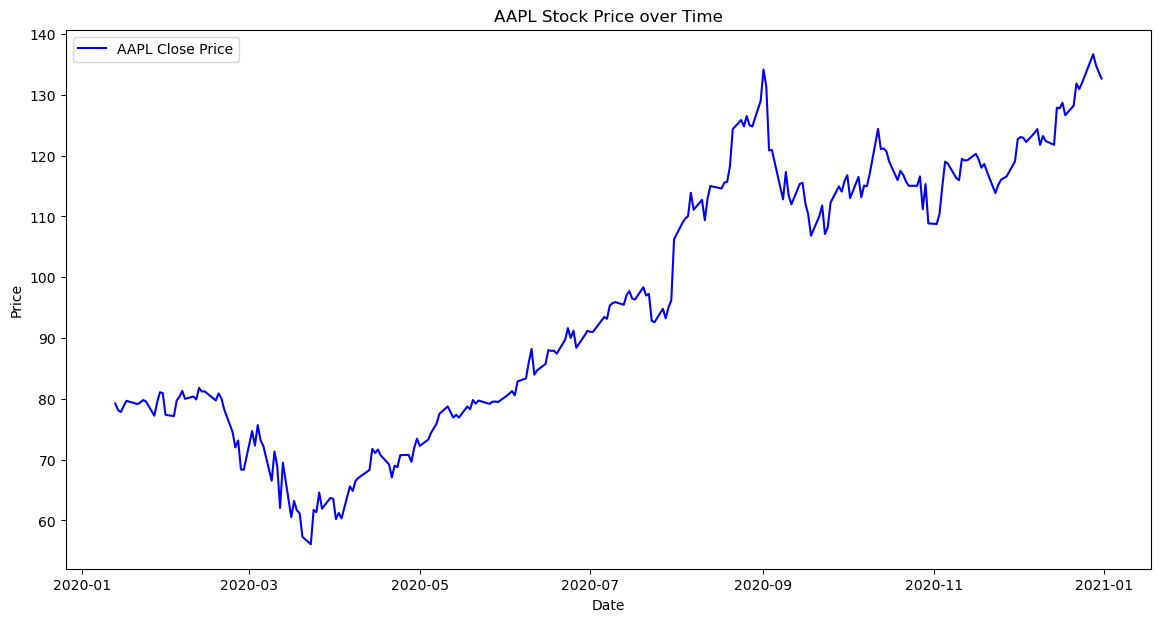

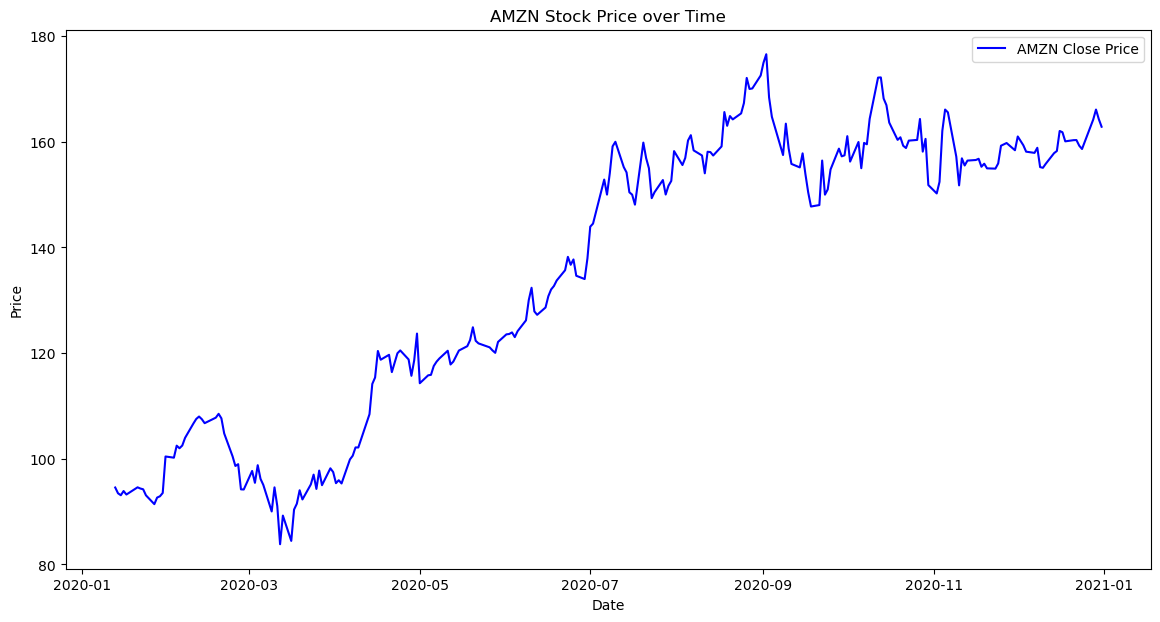

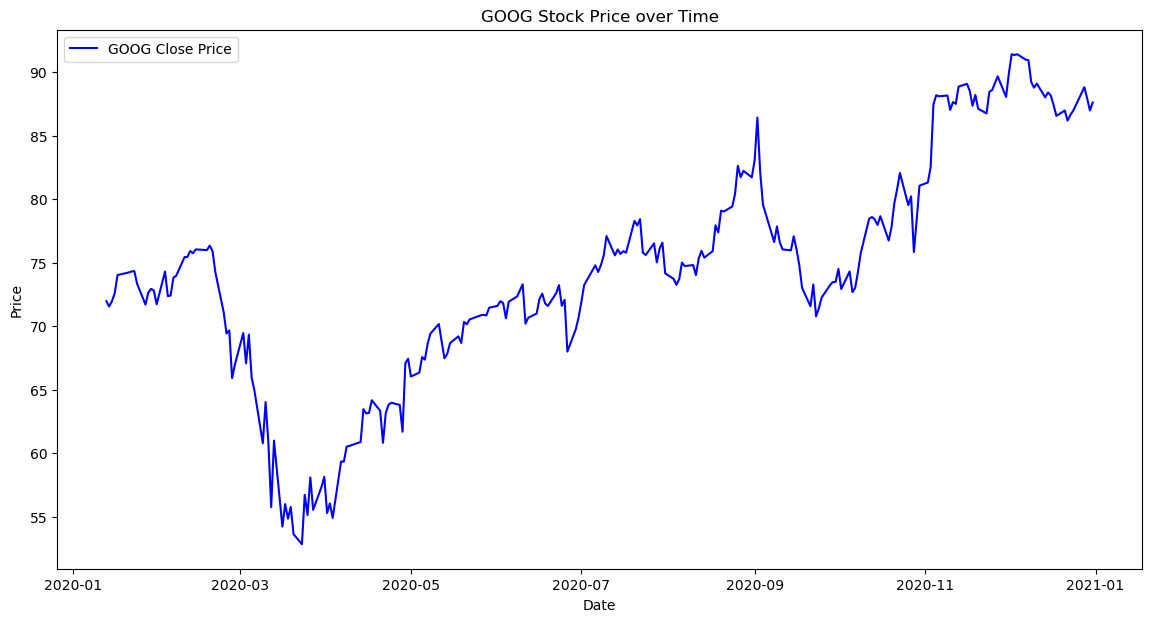

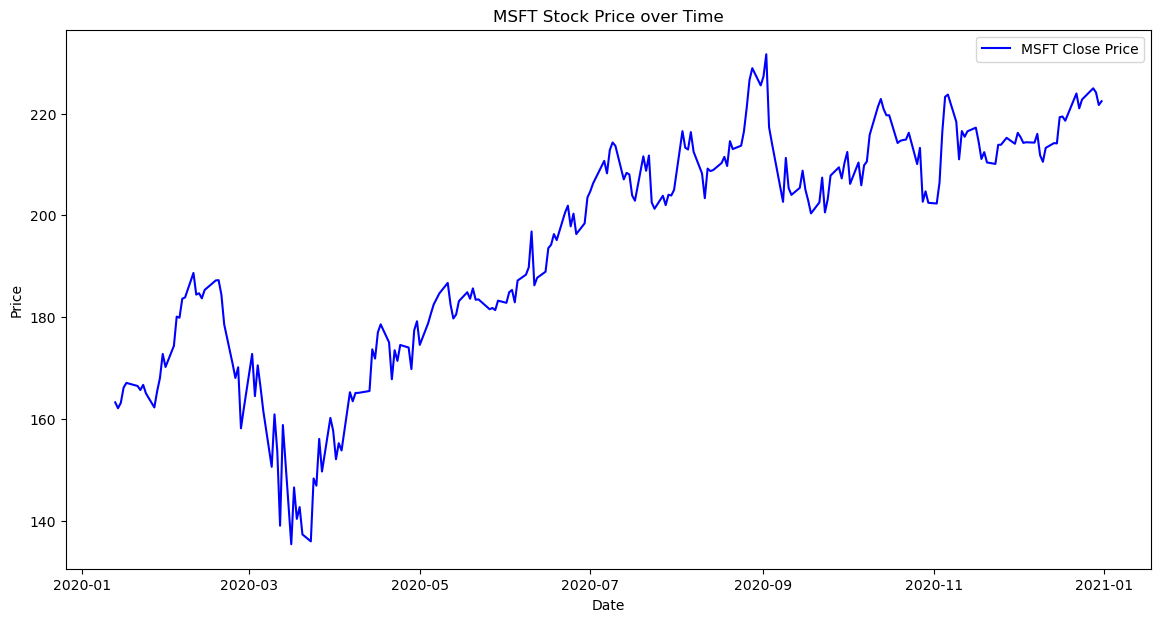

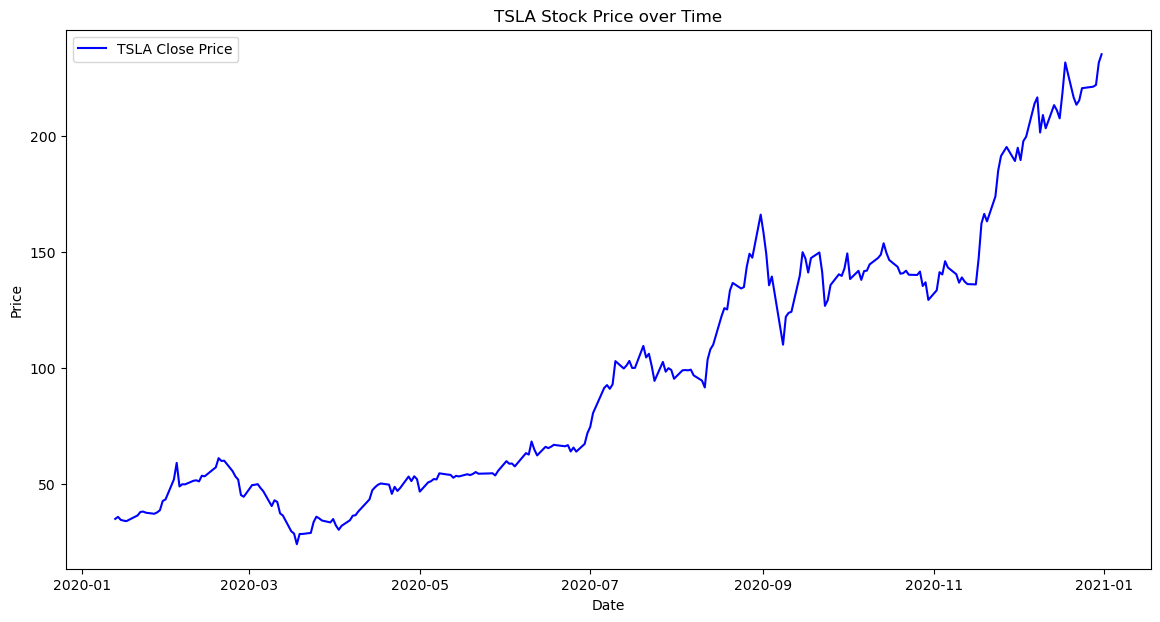

In [20]:
import matplotlib.pyplot as plt
import os

# Ensure the images directory exists
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Plot stock price for each company and save the image
for company in companies:
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data[company]['Date'], stock_data[company]['Close'], label=f'{company} Close Price', color='blue')
    plt.title(f'{company} Stock Price over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_stock_price.png')
    plt.savefig(image_path)
    plt.show()



## Time-Series Forecasting Visualizations
Saving  the forecasting results for 1-day, 3-day, and 7-day horizons. 

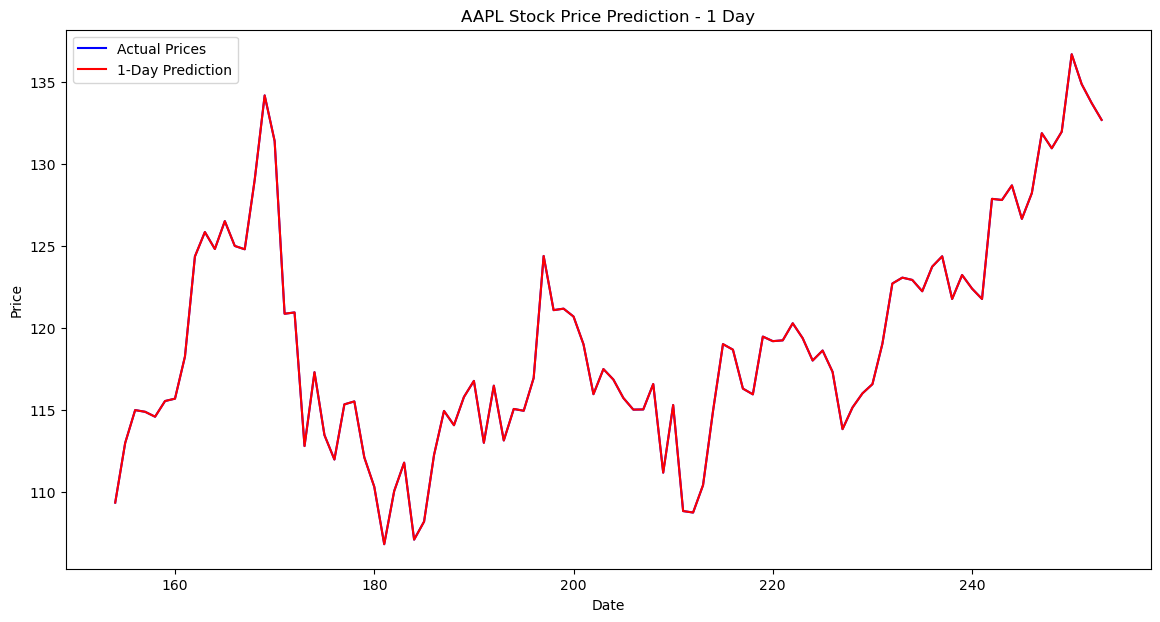

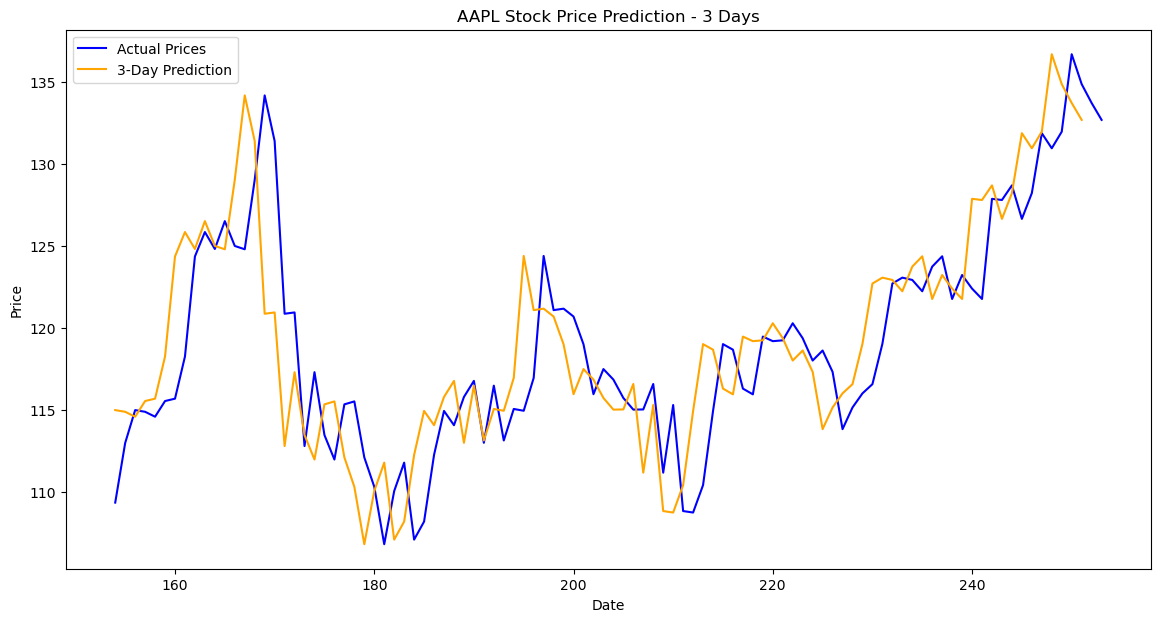

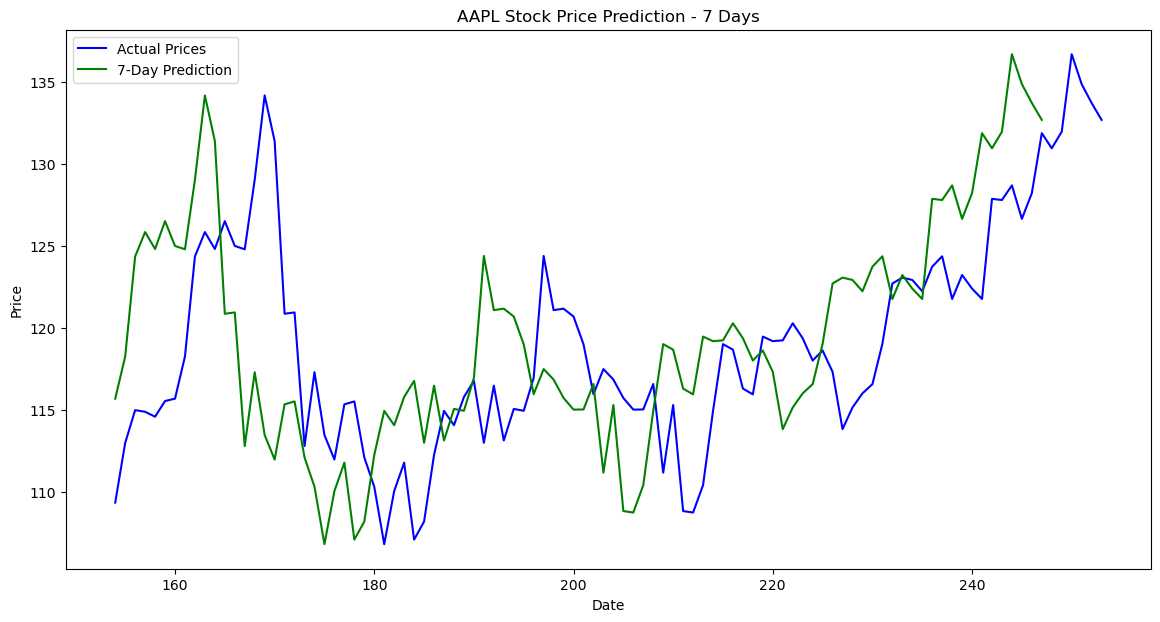

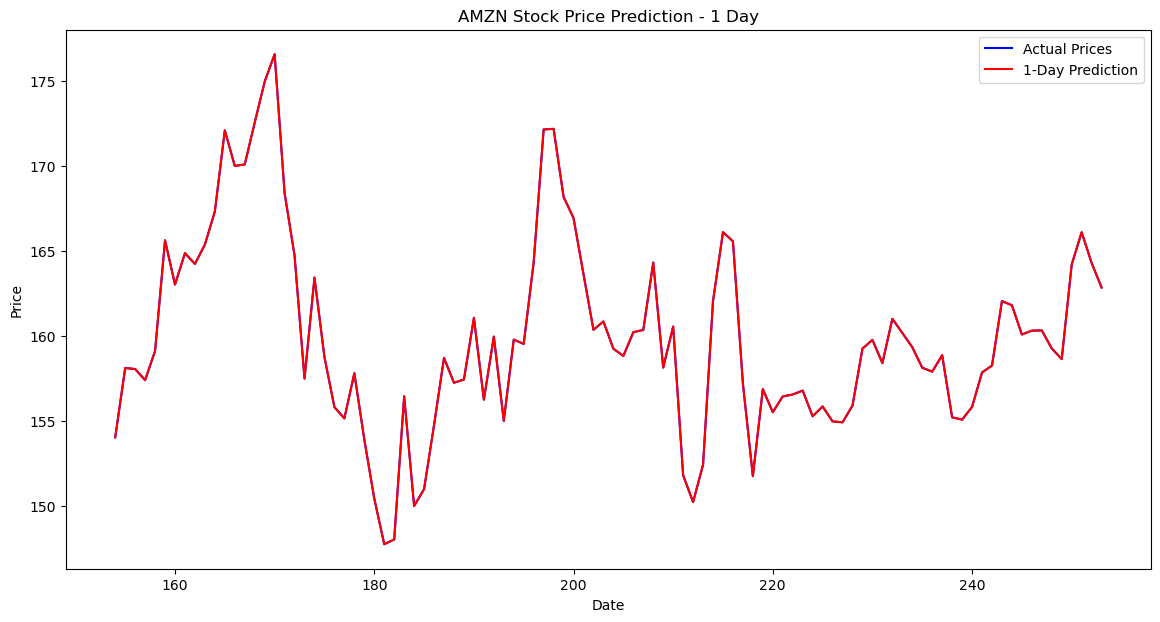

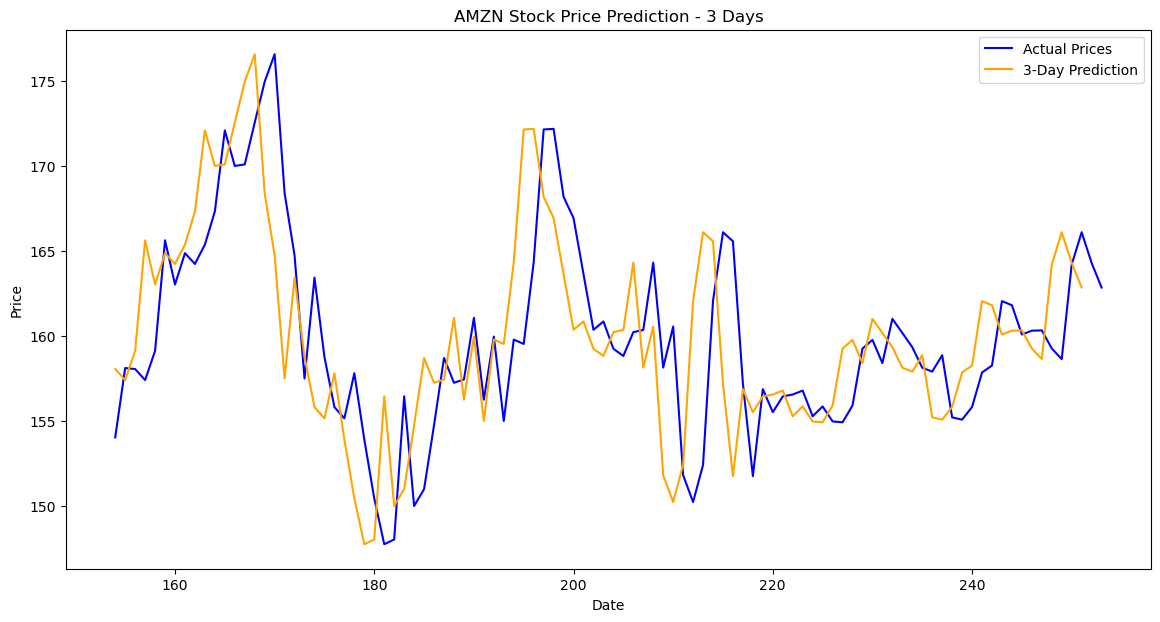

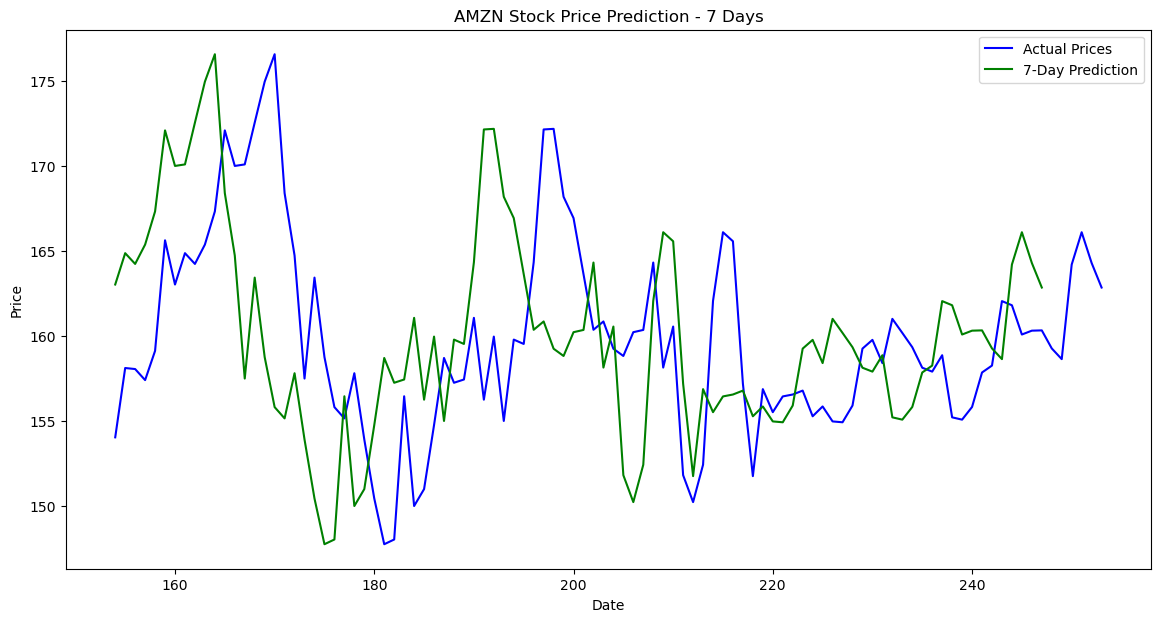

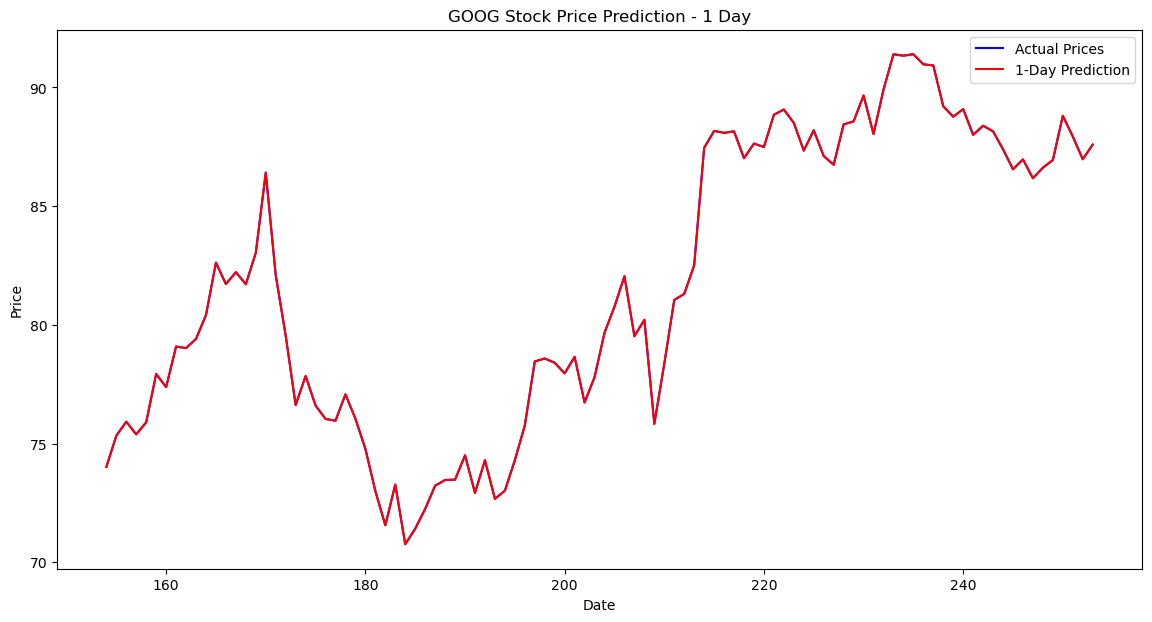

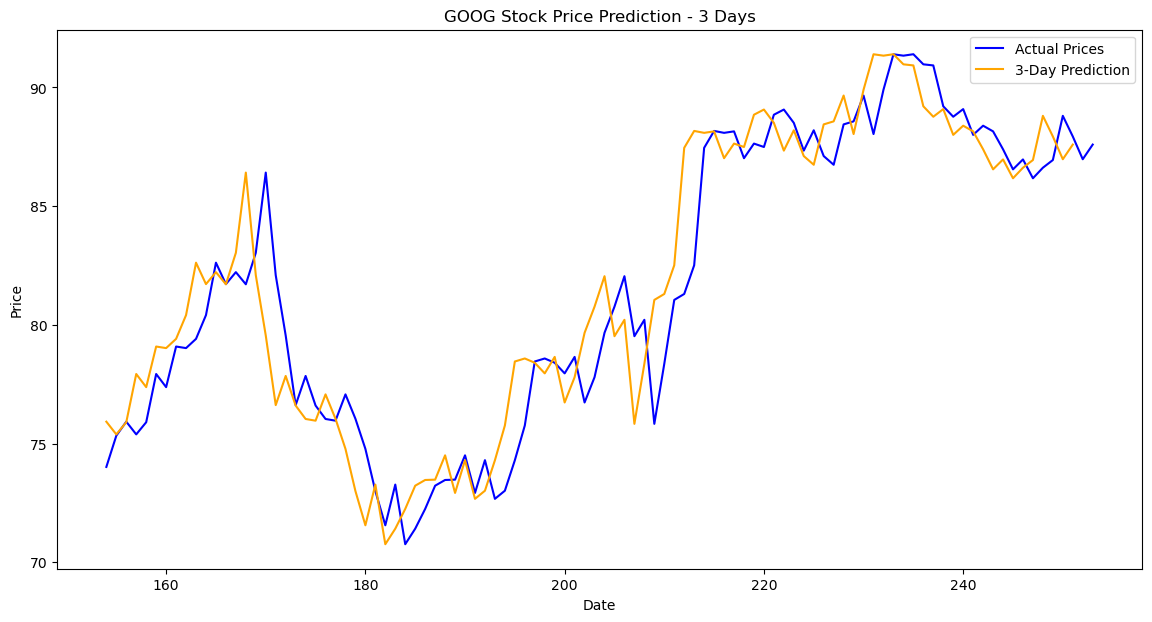

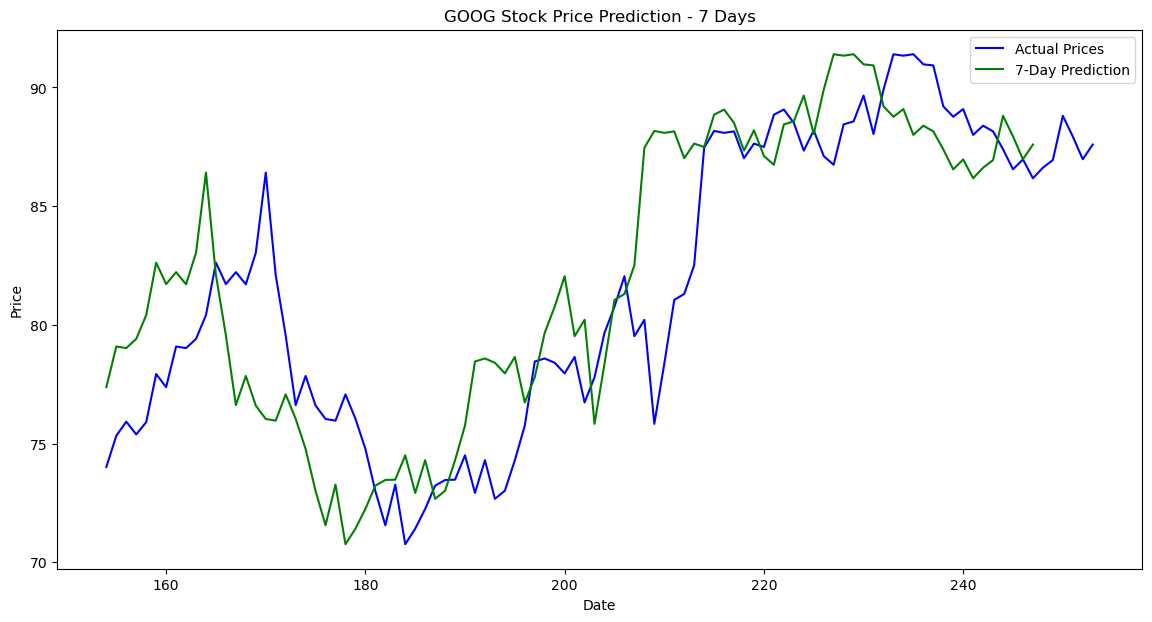

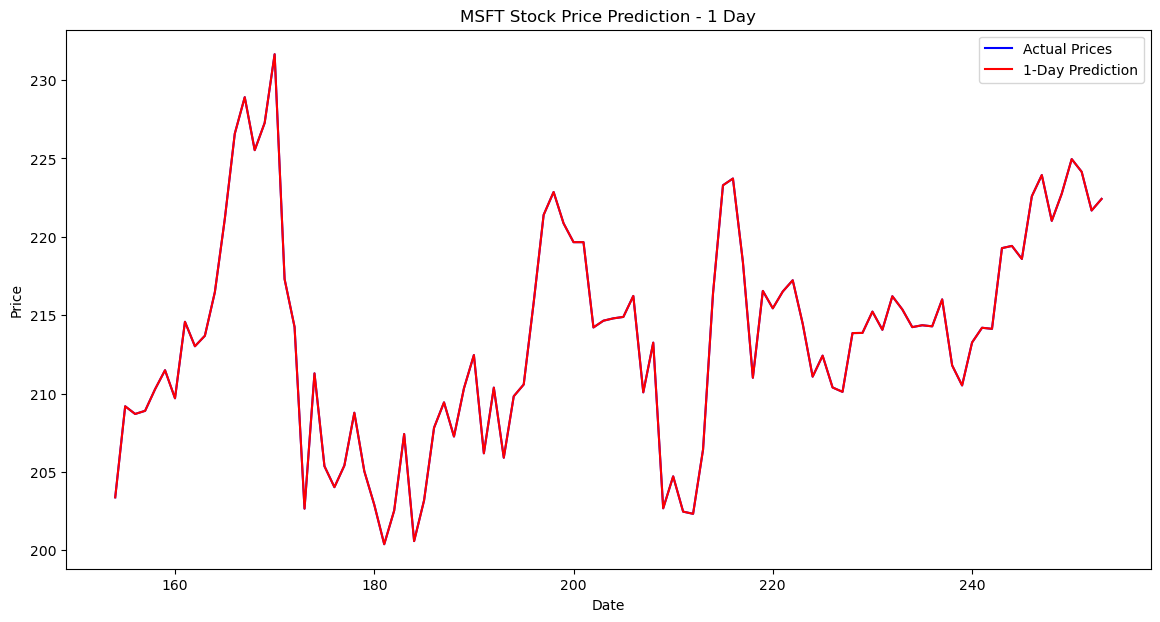

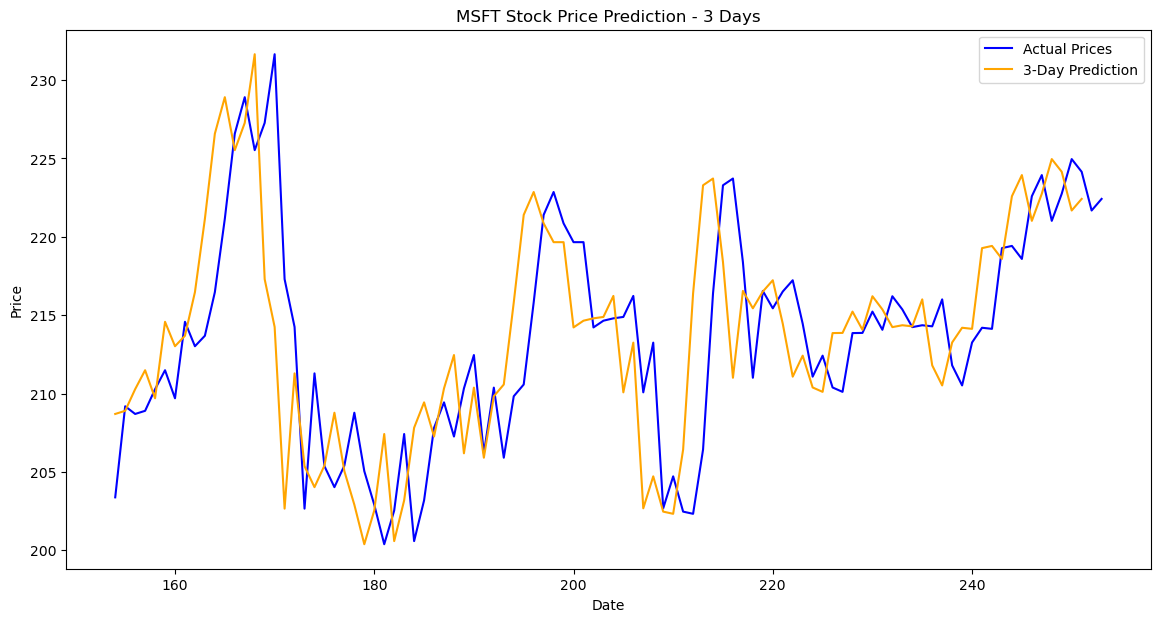

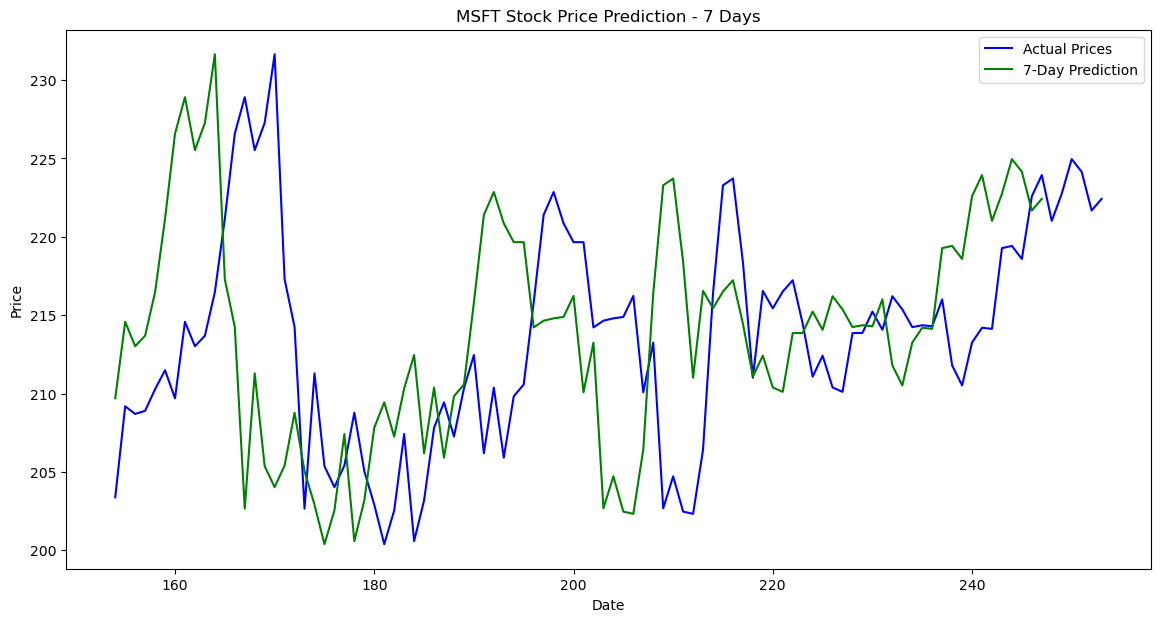

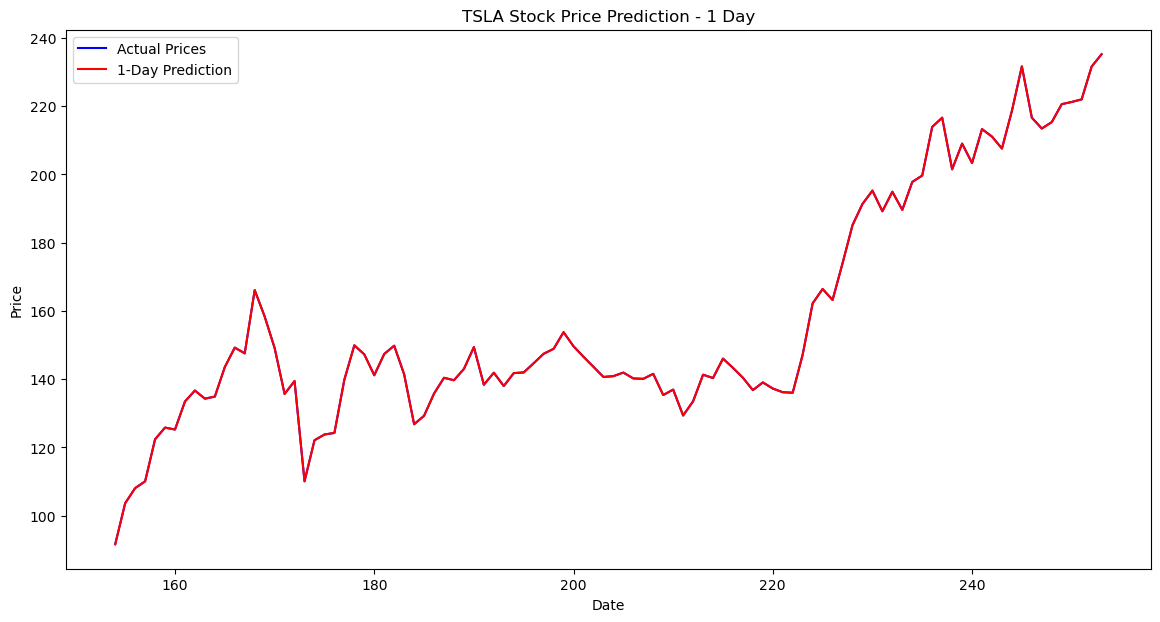

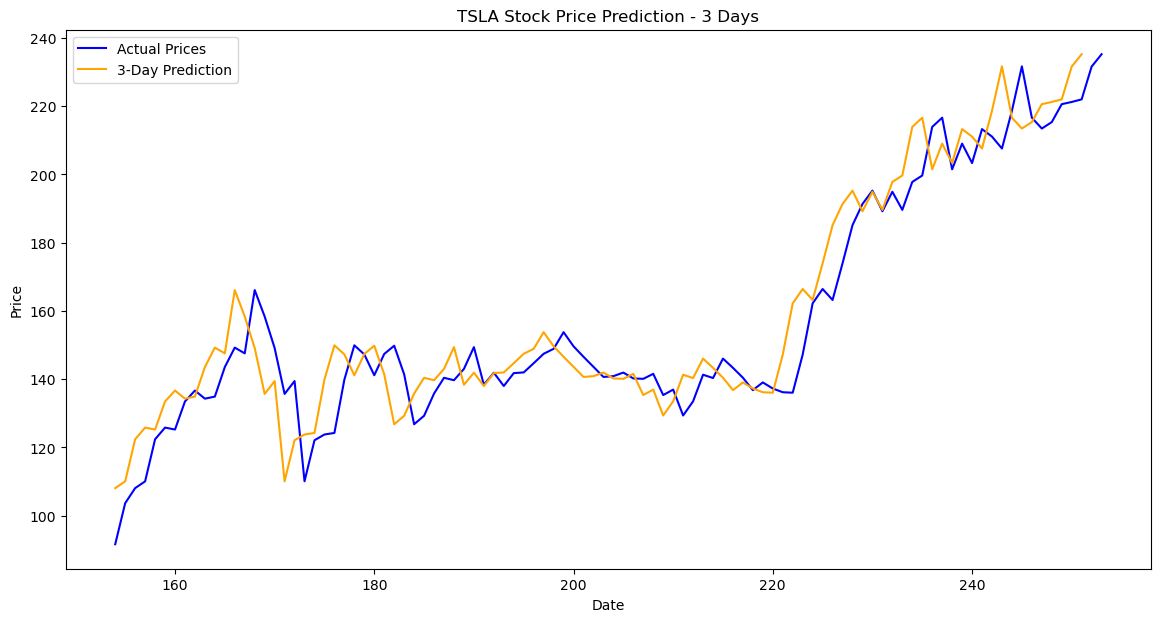

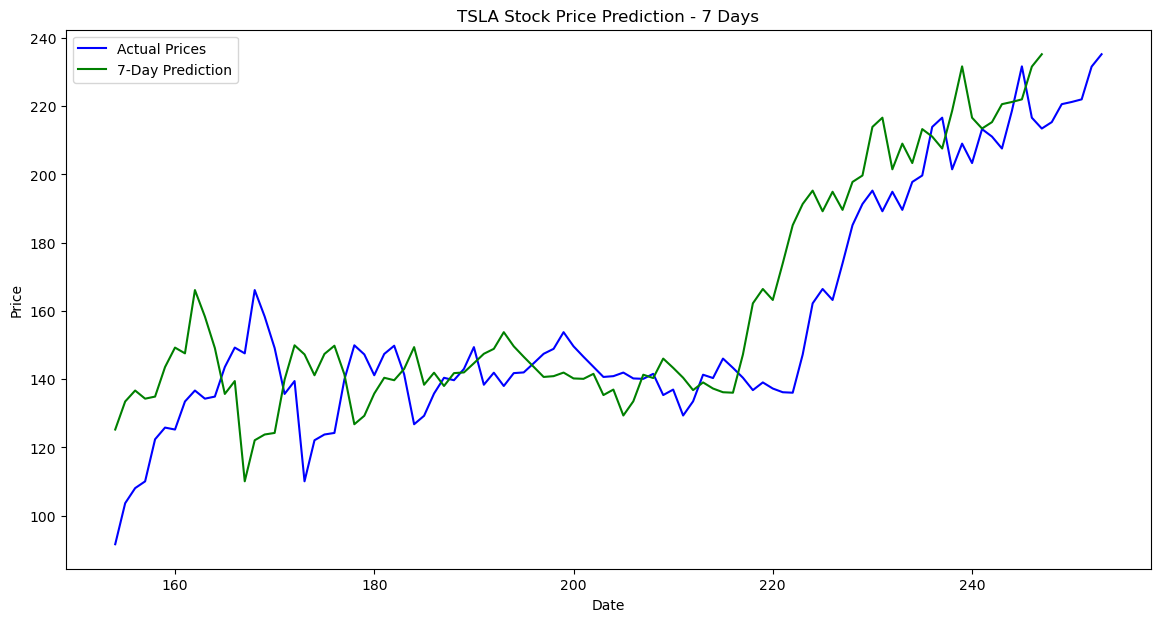

In [23]:
# Example: Assuming you have y_test, y_pred_1day, y_pred_3days, y_pred_7days ready for plotting
from sklearn.model_selection import train_test_split

# Example loop for saving the forecast images for each company and horizon
for company in companies:
    df = stock_data[company]
    
    # Assuming these are your predicted values (replace with actual predictions)
    y_test = df['Close'][-100:]  # Replace 100 with actual test size
    y_pred_1day = y_test  # Replace with actual 1-day prediction
    y_pred_3days = y_test.shift(-2)  # Replace with actual 3-day prediction
    y_pred_7days = y_test.shift(-6)  # Replace with actual 7-day prediction

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_1day, label='1-Day Prediction', color='red')
    plt.title(f'{company} Stock Price Prediction - 1 Day')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_1days.png')
    plt.savefig(image_path)
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_3days, label='3-Day Prediction', color='orange')
    plt.title(f'{company} Stock Price Prediction - 3 Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_3days.png')
    plt.savefig(image_path)
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_7days, label='7-Day Prediction', color='green')
    plt.title(f'{company} Stock Price Prediction - 7 Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_7days.png')
    plt.savefig(image_path)
    plt.show()


In [25]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Select the AAPL dataset
company = 'AAPL'
df = stock_data[company]

# Use the 'Close' price for forecasting
y = df['Close']

# Train an ARIMA model (you can experiment with different p, d, q values)
model = ARIMA(y, order=(5,1,0))  # Example with (p=5, d=1, q=0)
model_fit = model.fit()

# Forecast the next 7 days
forecast_1day = model_fit.forecast(steps=1)
forecast_3days = model_fit.forecast(steps=3)
forecast_7days = model_fit.forecast(steps=7)

# Prepare actual and predicted data for plotting (example with the last 100 points)
y_test = y[-100:]
y_pred_1day = np.append(y_test.values[:-1], forecast_1day)
y_pred_3days = np.append(y_test.values[:-3], forecast_3days)
y_pred_7days = np.append(y_test.values[:-7], forecast_7days)


C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

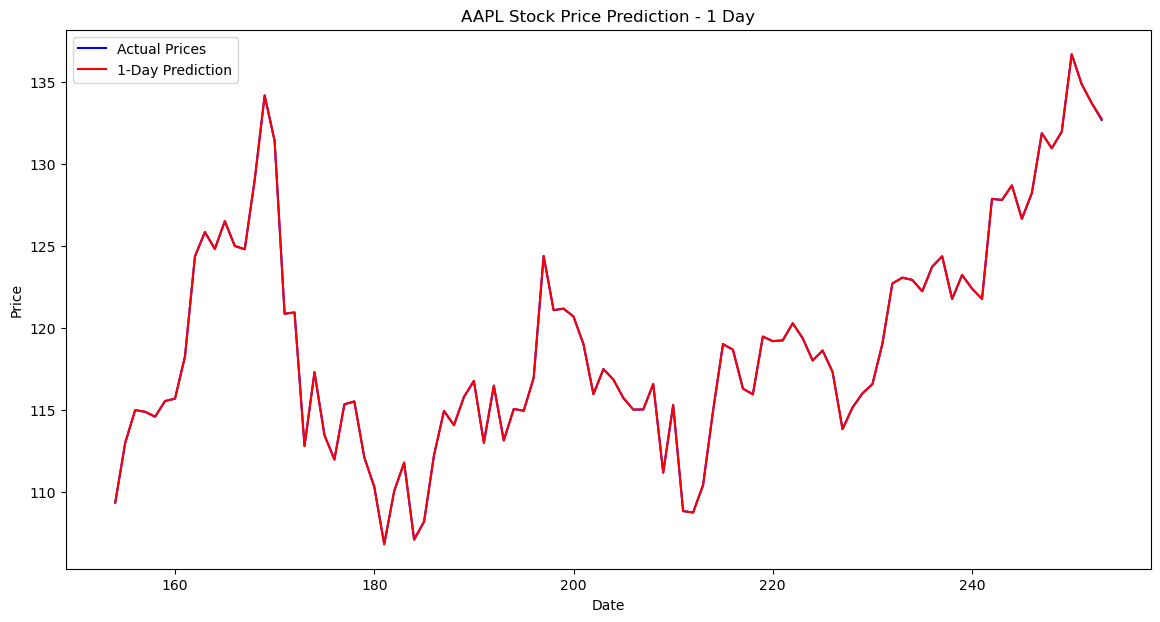

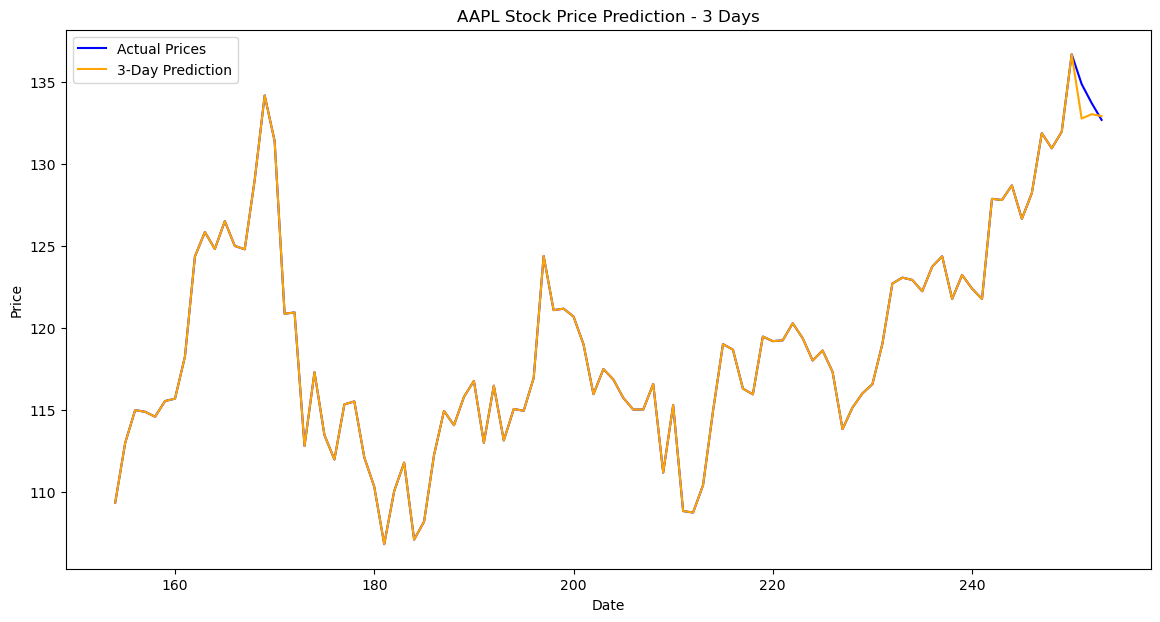

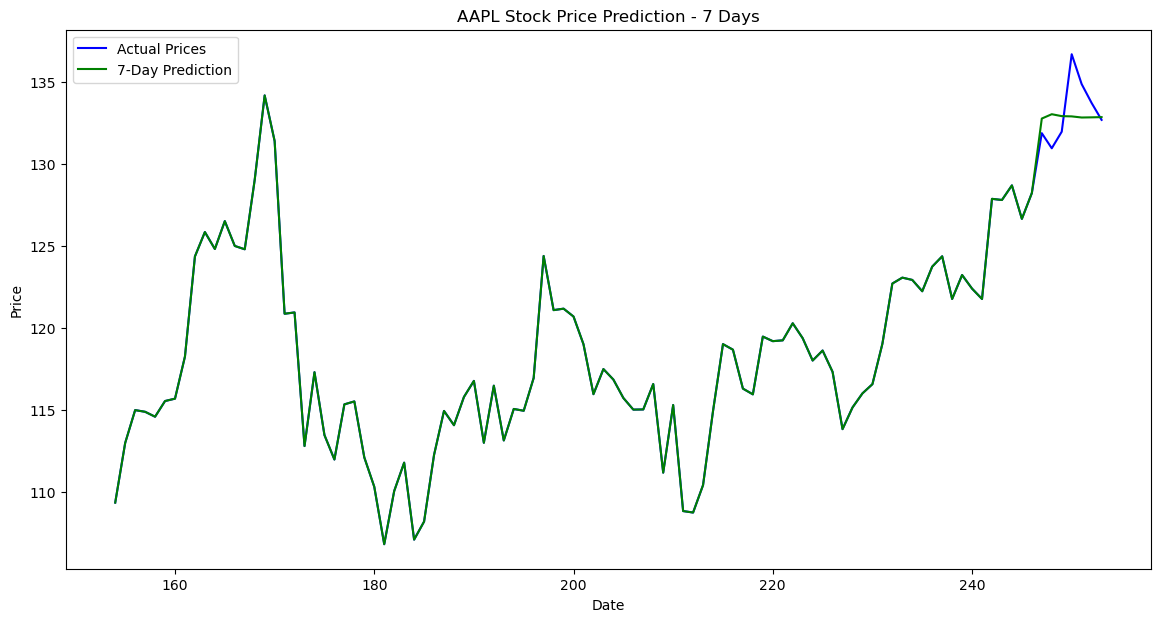

In [57]:
import matplotlib.pyplot as plt
import os

# Ensure the images directory exists
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Plot and save 1-day forecast
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred_1day, label='1-Day Prediction', color='red')
plt.title(f'{company} Stock Price Prediction - 1 Day')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
image_path = os.path.join(images_dir, f'{company}_forecast_1days.png')
plt.savefig(image_path)
plt.show()

# Plot and save 3-day forecast
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred_3days, label='3-Day Prediction', color='orange')
plt.title(f'{company} Stock Price Prediction - 3 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
image_path = os.path.join(images_dir, f'{company}_forecast_3days.png')
plt.savefig(image_path)
plt.show()

# Plot and save 7-day forecast
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred_7days, label='7-Day Prediction', color='green')
plt.title(f'{company} Stock Price Prediction - 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
image_path = os.path.join(images_dir, f'{company}_forecast_7days.png')
plt.savefig(image_path)
plt.show()


C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

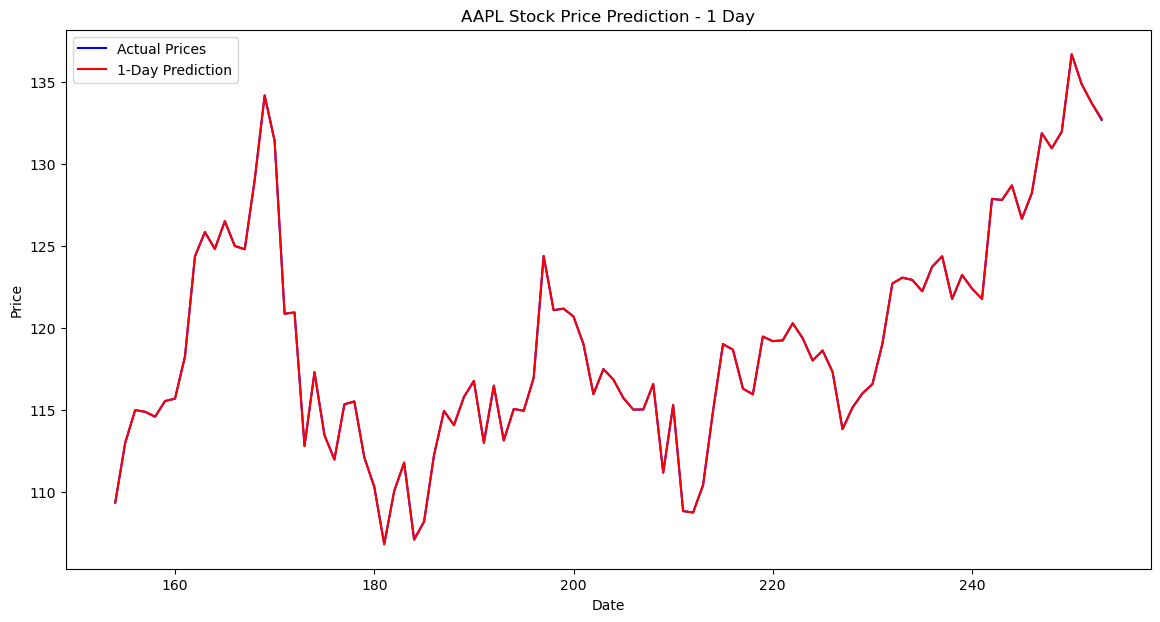

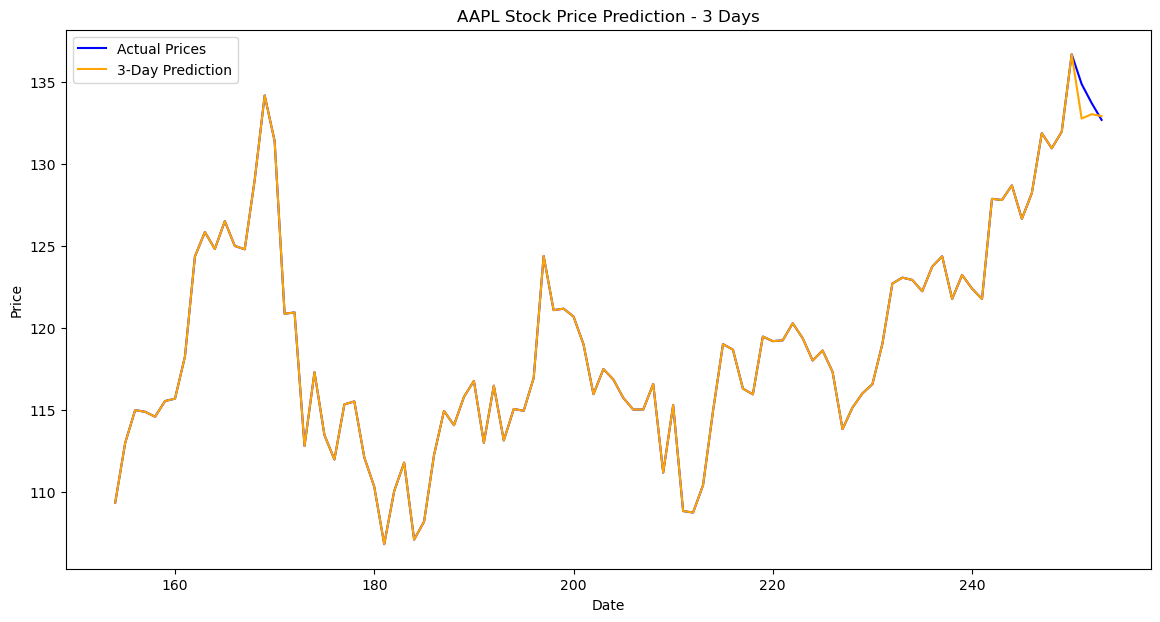

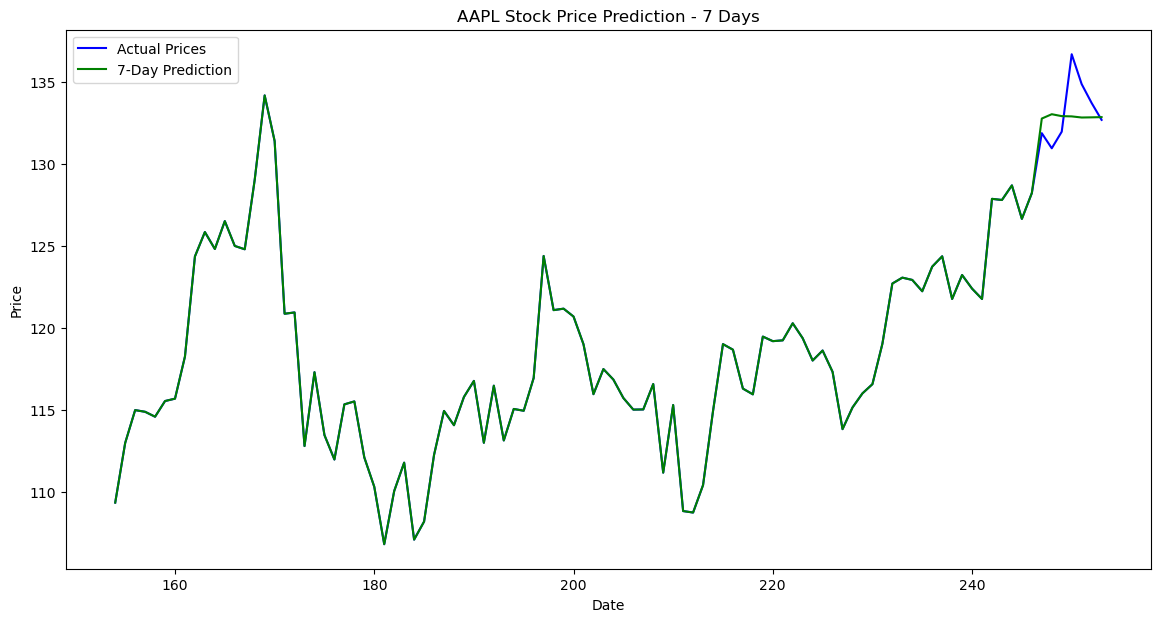

C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

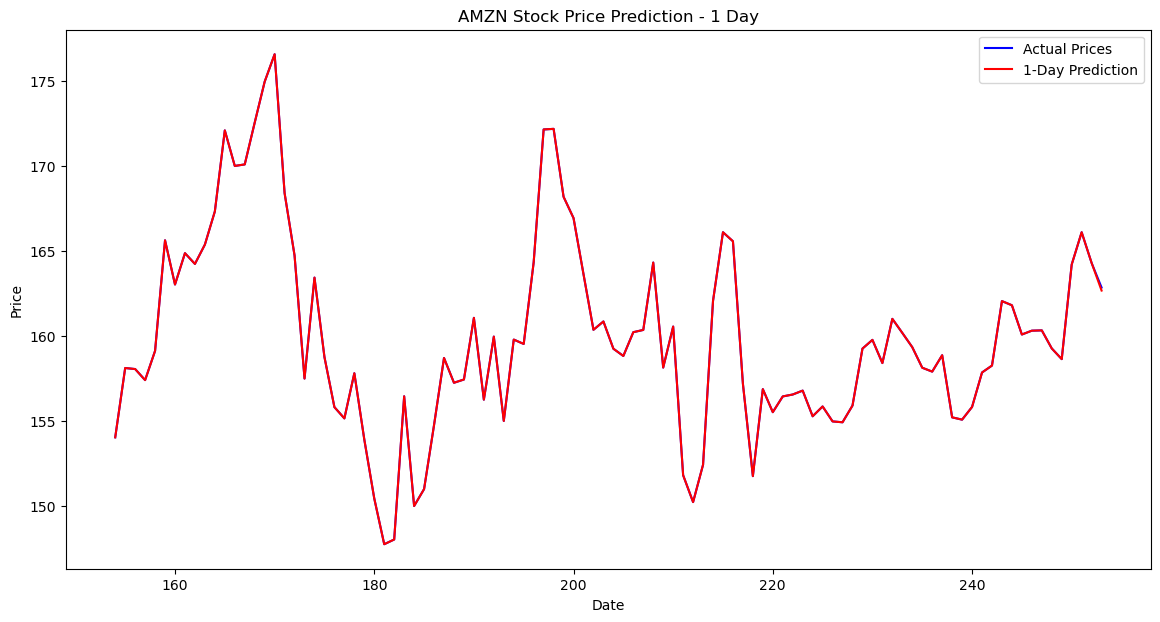

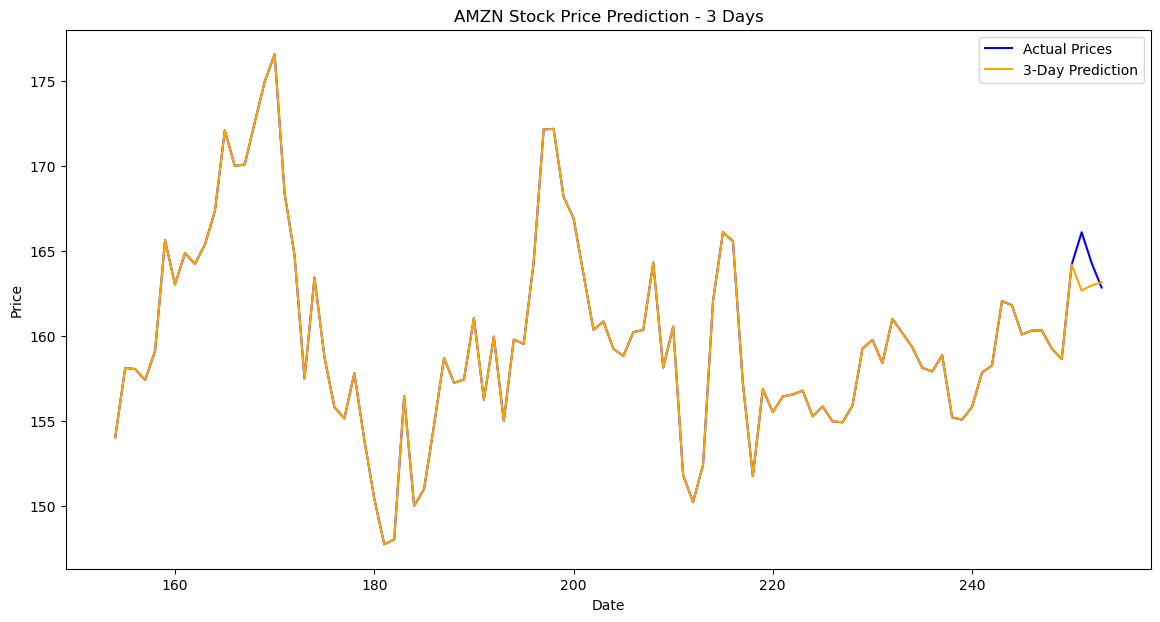

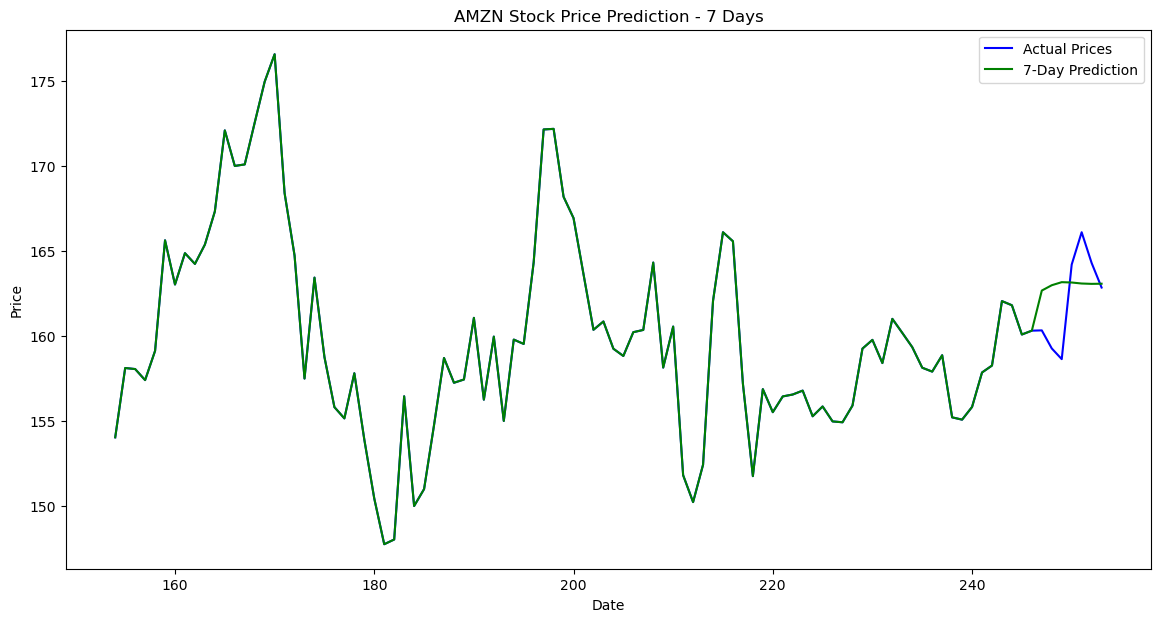

C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

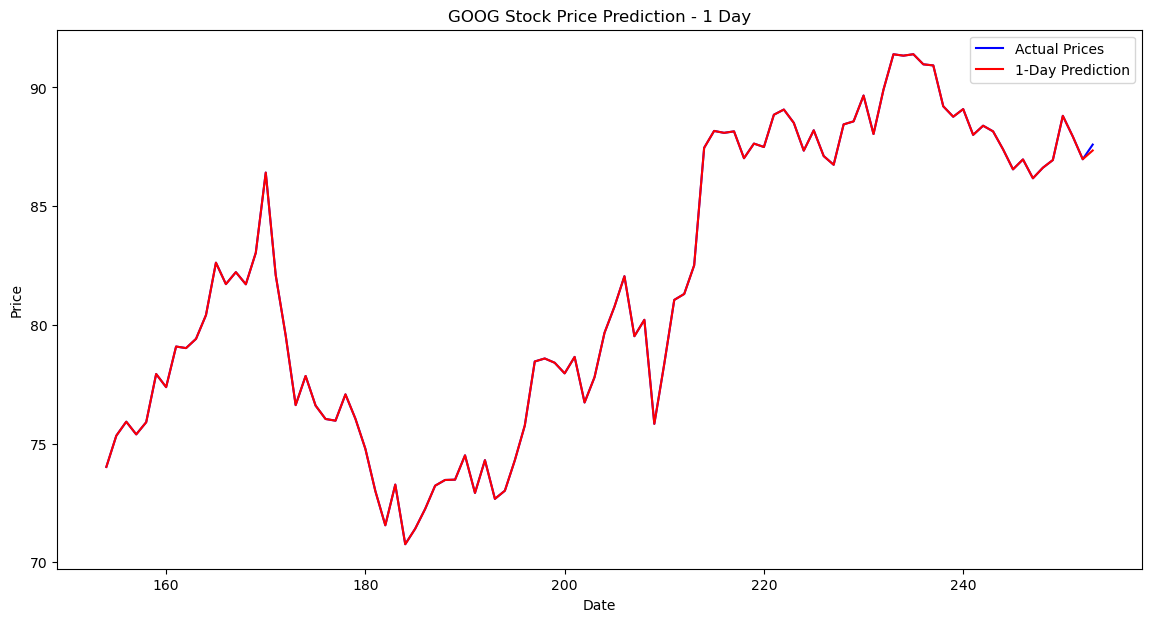

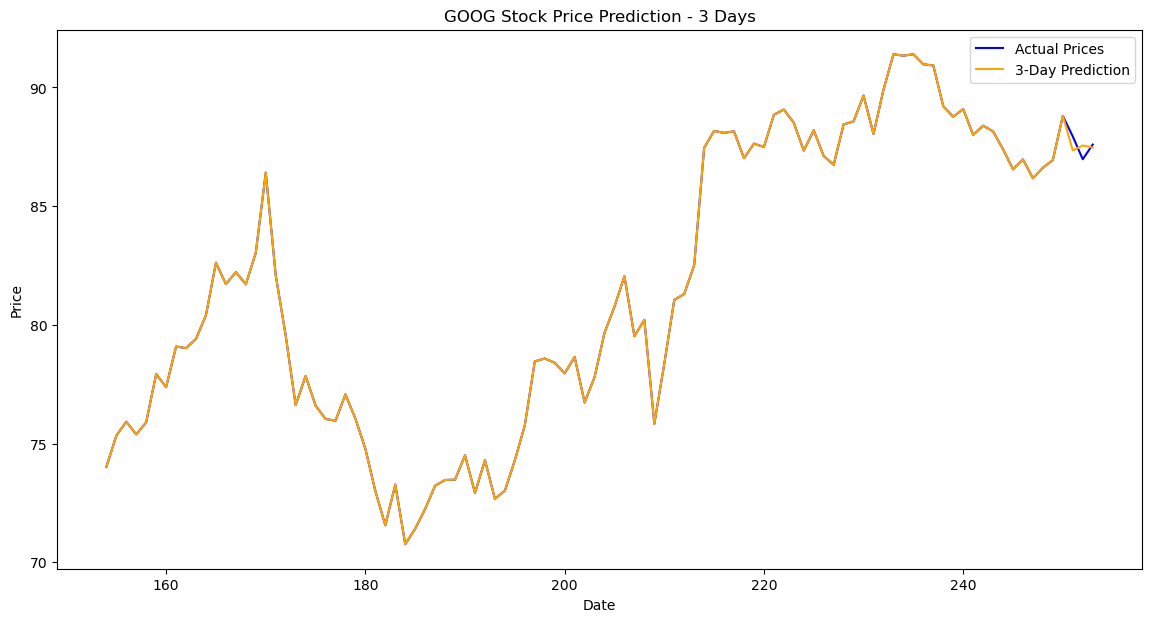

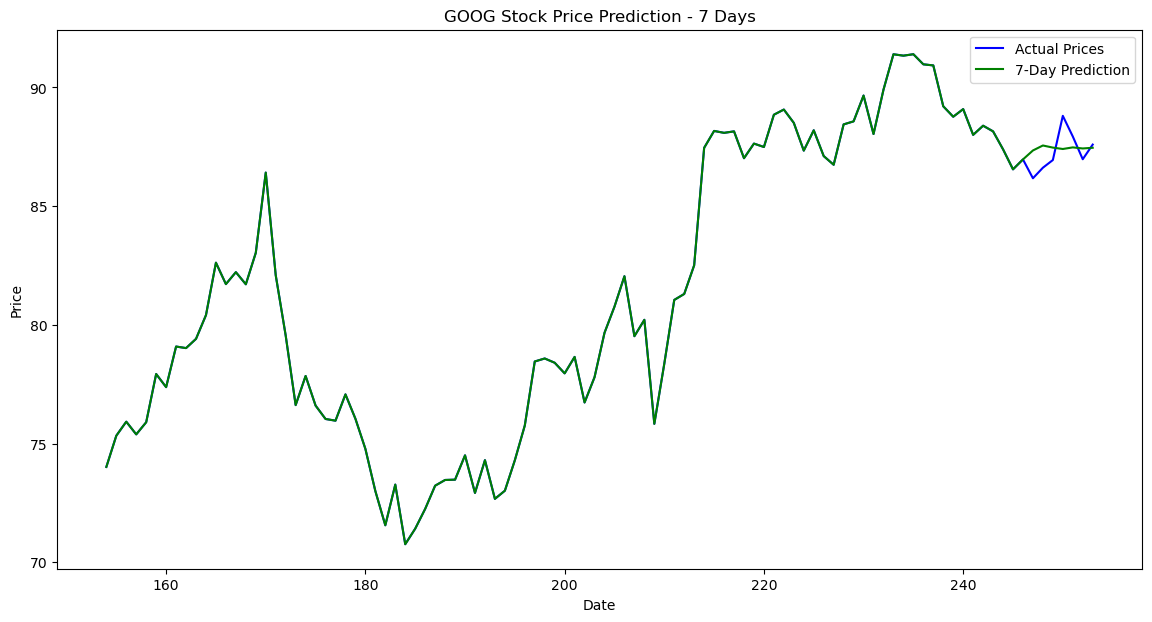

C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

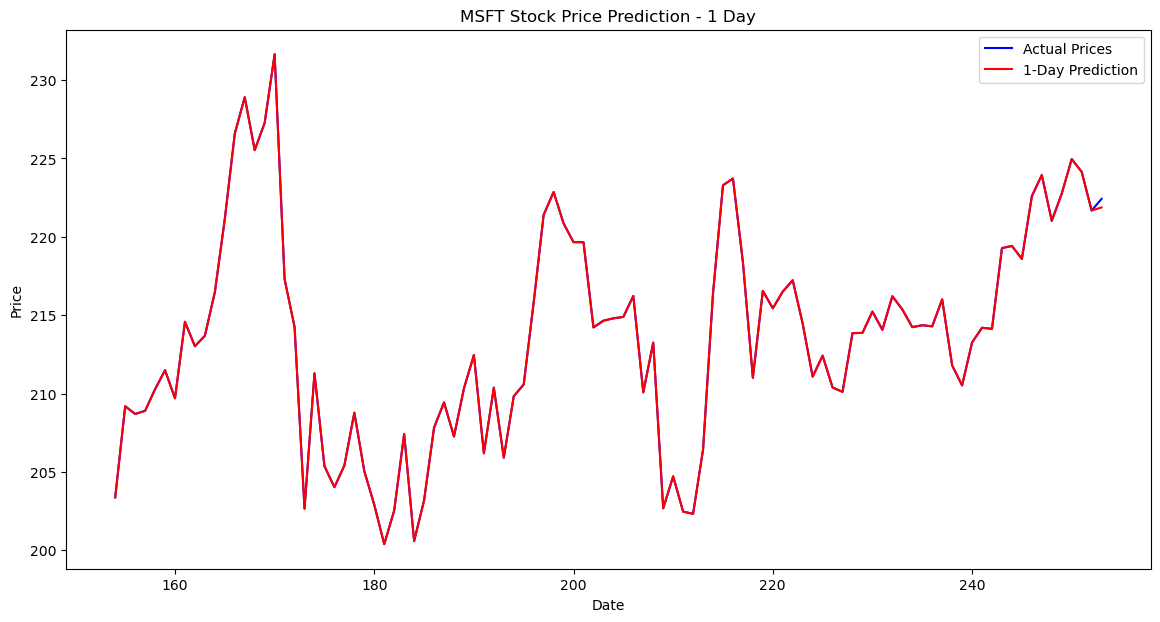

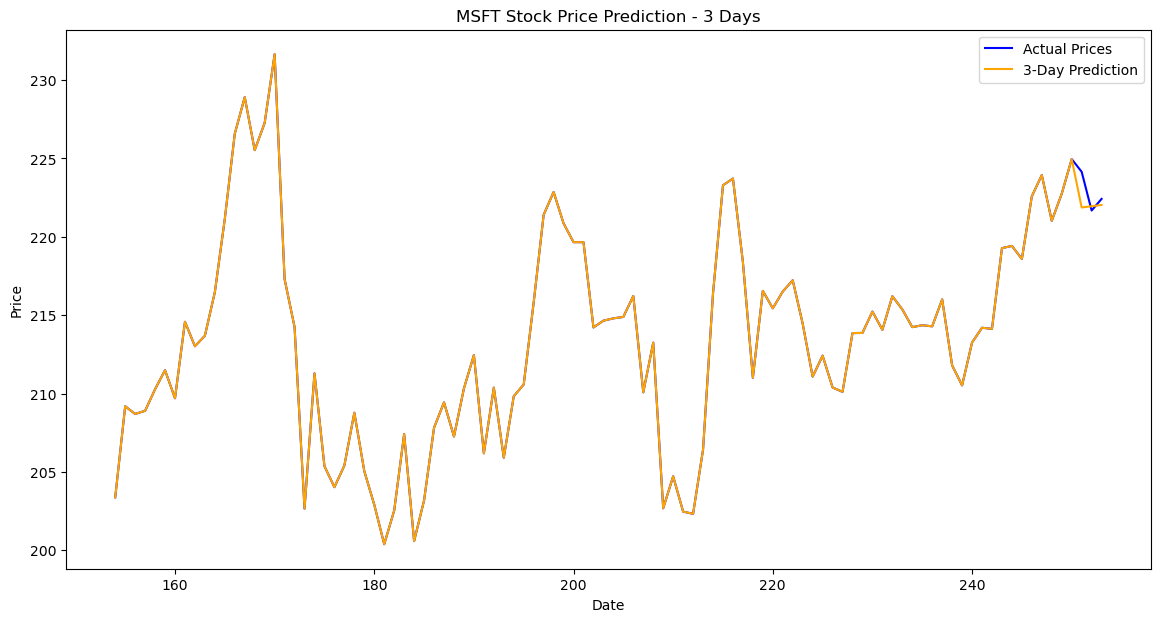

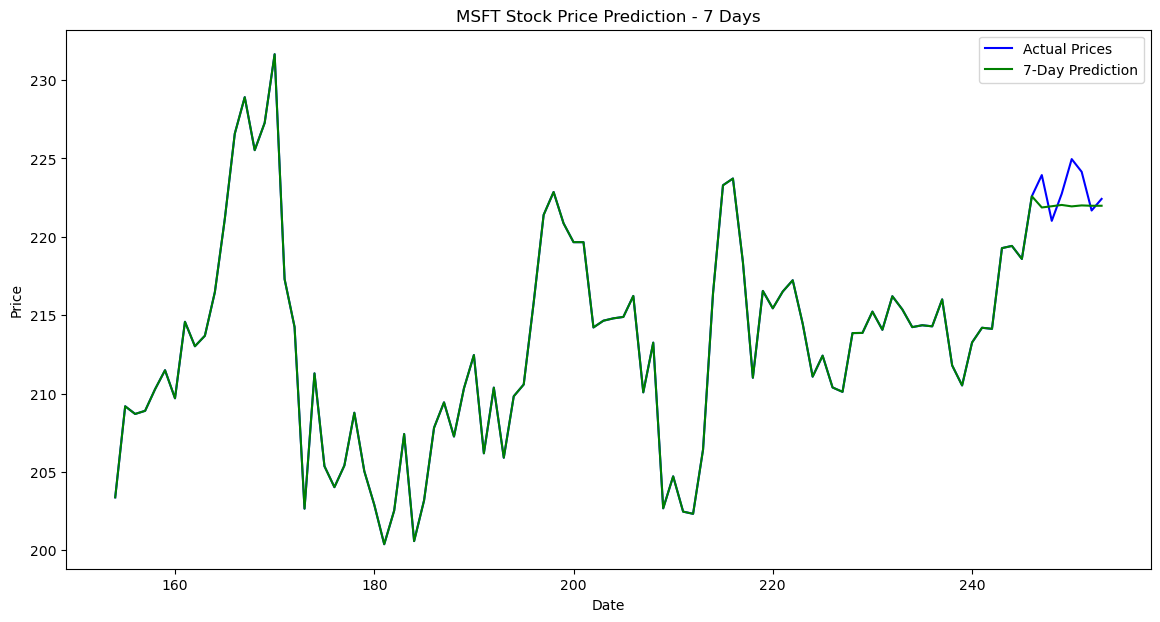

C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ronan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

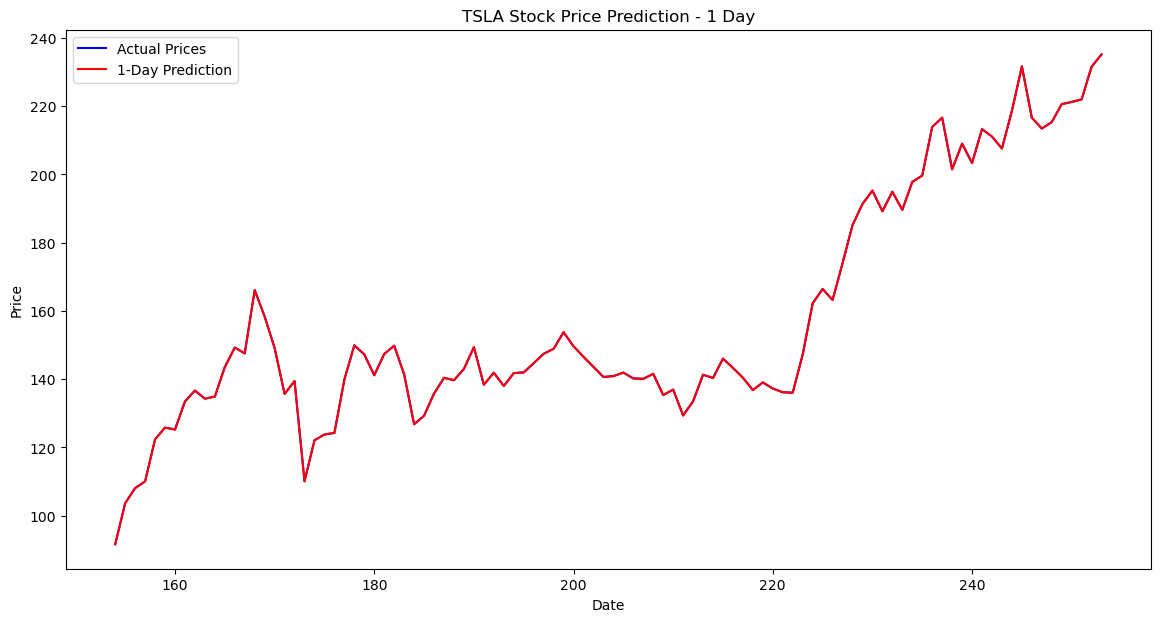

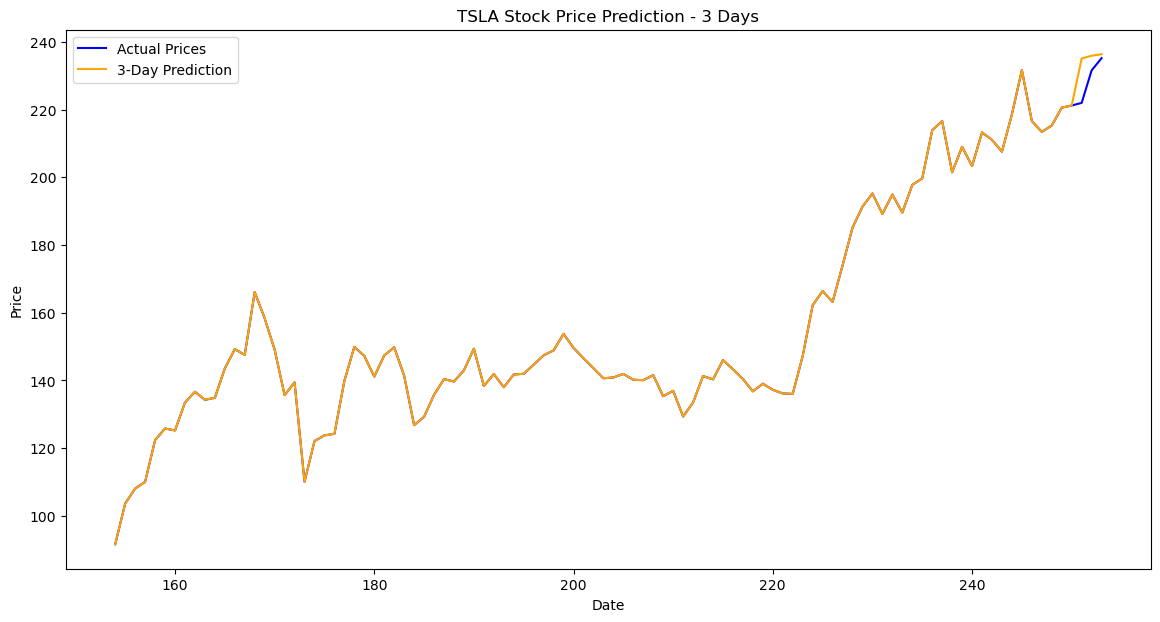

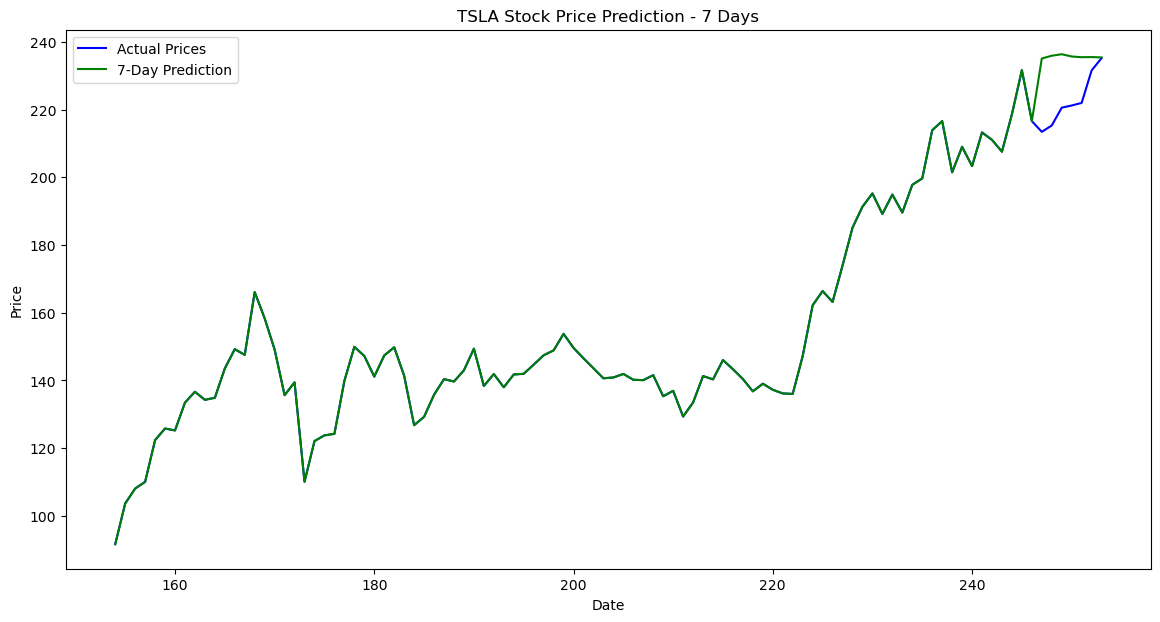

In [59]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure the images directory exists
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Loop through each company and generate forecasts
for company in companies:
    df = stock_data[company]
    
    # Use the 'Close' price for forecasting
    y = df['Close']

    # Train an ARIMA model (example with (p=5, d=1, q=0), adjust as needed)
    model = ARIMA(y, order=(5,1,0))
    model_fit = model.fit()

    # Forecast the next 1, 3, and 7 days
    forecast_1day = model_fit.forecast(steps=1)
    forecast_3days = model_fit.forecast(steps=3)
    forecast_7days = model_fit.forecast(steps=7)

    # Prepare actual and predicted data for plotting (example with the last 100 points)
    y_test = y[-100:]
    y_pred_1day = np.append(y_test.values[:-1], forecast_1day)
    y_pred_3days = np.append(y_test.values[:-3], forecast_3days)
    y_pred_7days = np.append(y_test.values[:-7], forecast_7days)

    # Plot and save 1-day forecast
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_1day, label='1-Day Prediction', color='red')
    plt.title(f'{company} Stock Price Prediction - 1 Day')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_1days.png')
    plt.savefig(image_path)
    plt.show()

    # Plot and save 3-day forecast
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_3days, label='3-Day Prediction', color='orange')
    plt.title(f'{company} Stock Price Prediction - 3 Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_3days.png')
    plt.savefig(image_path)
    plt.show()

    # Plot and save 7-day forecast
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
    plt.plot(y_test.index, y_pred_7days, label='7-Day Prediction', color='green')
    plt.title(f'{company} Stock Price Prediction - 7 Days')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    image_path = os.path.join(images_dir, f'{company}_forecast_7days.png')
    plt.savefig(image_path)
    plt.show()


## SQL Query Code

In [69]:
import pandas as pd
import os
import zipfile
from sqlalchemy import create_engine, text

# Unzip the dataset
with zipfile.ZipFile('stock-tweet-and-price.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the tweet dataset using Pandas for simplicity
tweets_df = pd.read_csv('stock-tweet-and-price/stocktweet/stocktweet.csv')

# Load the stock price data into Pandas DataFrames for simplicity
companies = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
stock_data = {}

for company in companies:
    stock_data[company] = pd.read_csv(f'stock-tweet-and-price/stockprice/{company}.csv')

# Example SQL-based processing - Store data in SQL database for later querying
engine = create_engine('sqlite:///stock_data.db')
for company in companies:
    stock_data[company].to_sql(company.lower(), engine, if_exists='replace', index=False)
    
# Example SQL query to demonstrate use of SQL verbs
with engine.connect() as conn:
    result = conn.execute(text("SELECT * FROM aapl WHERE Close > 300"))
    for row in result:
        print(row)


## Python Code to Calculate Evaluation Metrics

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for each forecast
for company in companies:
    df = stock_data[company]
    y_test = df['Close'][-100:]  # Replace 100 with actual test size

    # Assuming y_pred_1day, y_pred_3days, y_pred_7days are your forecasted values
    rmse_1day = sqrt(mean_squared_error(y_test[:-1], y_pred_1day[:-1]))
    rmse_3days = sqrt(mean_squared_error(y_test[:-3], y_pred_3days[:-3]))
    rmse_7days = sqrt(mean_squared_error(y_test[:-7], y_pred_7days[:-7]))

    print(f"RMSE for {company} - 1 Day: {rmse_1day}")
    print(f"RMSE for {company} - 3 Days: {rmse_3days}")
    print(f"RMSE for {company} - 7 Days: {rmse_7days}")


RMSE for AAPL - 1 Day: 47.48148848123259
RMSE for AAPL - 3 Days: 46.0864757467705
RMSE for AAPL - 7 Days: 43.657152510825505
RMSE for AMZN - 1 Day: 33.22701522579625
RMSE for AMZN - 3 Days: 32.37116871936723
RMSE for AMZN - 7 Days: 30.86382935942103
RMSE for GOOG - 1 Day: 80.46460428651316
RMSE for GOOG - 3 Days: 78.78551476693139
RMSE for GOOG - 7 Days: 75.77076042801231
RMSE for MSFT - 1 Day: 64.53196285656298
RMSE for MSFT - 3 Days: 65.18570913981105
RMSE for MSFT - 7 Days: 66.55978271636823
RMSE for TSLA - 1 Day: 0.0
RMSE for TSLA - 3 Days: 0.0
RMSE for TSLA - 7 Days: 0.0
